In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
import pandas as pd
from src.kitti.src.kitti_util import *

TRACKING_COLUMN_NAMES = ['frame','track_id','type','truncated','occluded','alpha','bbox_left','bbox_top',
                    'bbox_right','bbox_bottom','height','width','length','pos_x','pos_y','pos_z','rot_y']


def read_point_cloud(path):
    return np.fromfile(path,dtype=np.float32).reshape(-1,4)

def read_tracking(path):
    df = pd.read_csv(path,header=None,sep=' ')
    df.columns = TRACKING_COLUMN_NAMES
    df.loc[df.type.isin(['Truck','Van','Tram']),'type'] = 'Car'
    df = df[df.type.isin(['Car','Pedestrian','Cyclist'])]
    return df

def draw_point_cloud(ax, points, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        axes_limits = [
            [-20,80],# X axis range
            [-20,20],# Y axis range
            [-3,3],# Z axis range    
        ]
        axes_str = ['X','Y','Z']
        ax.grid(False)
        point_size = 0.05
        ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
        ax.set_title(points)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)
        
def compute_3d_box_cam2(h,w,l,x,y,z,yaw):
    """
    Return :3xn in cam2 coordinate
    """
    R = np.array([[np.cos(yaw),0,np.sin(yaw)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])
    x_corners = [l/2, l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]
    y_corners = [0,   0,    0,    0,   -h,   -h,   -h,   -h  ]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2  ]
    corners_3d_cam2 = np.dot(R,np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2 += np.vstack([x,y,z])
    return corners_3d_cam2

DATA_PATH = './a_data/RawData/2011_09_26/2011_09_26_drive_0005_sync/'

points= read_point_cloud(os.path.join(DATA_PATH,'velodyne_points/data/%010d.bin'%0))  

calib = Calibration('./a_data/RawData/2011_09_26/',from_video=True)
df_tracking = read_tracking('./a_data/tracking/training/label_02/0000.txt')


corners_3d_cam2 =compute_3d_box_cam2(*df_tracking.loc[2,['height','width','length','pos_x','pos_y','pos_z','rot_y']])

corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T)


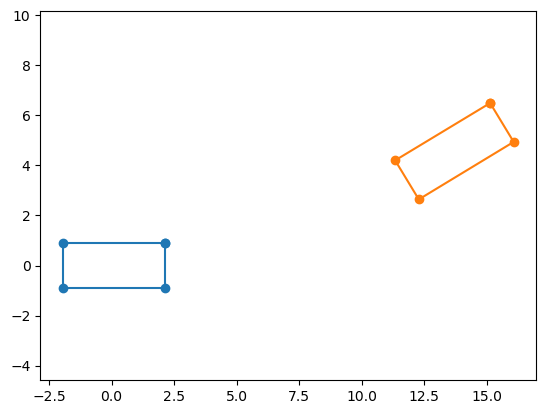

In [11]:
ego_car = np.array([[2.15,0.9,-1.73],[2.15,-0.9,-1.73],[-1.95,-0.9,-1.73],[-1.95,0.9,-1.73],
                    [2.15,0.9,-0.23],[2.15,-0.9,-0.23],[-1.95,-0.9,-0.23],[-1.95,0.9,-0.23]])
plt.axes().set_aspect('equal','datalim')
plt.plot(ego_car[:5,0],ego_car[:5,1],'-o')
plt.plot(corners_3d_velo[:5,0],corners_3d_velo[:5,1],'-o')

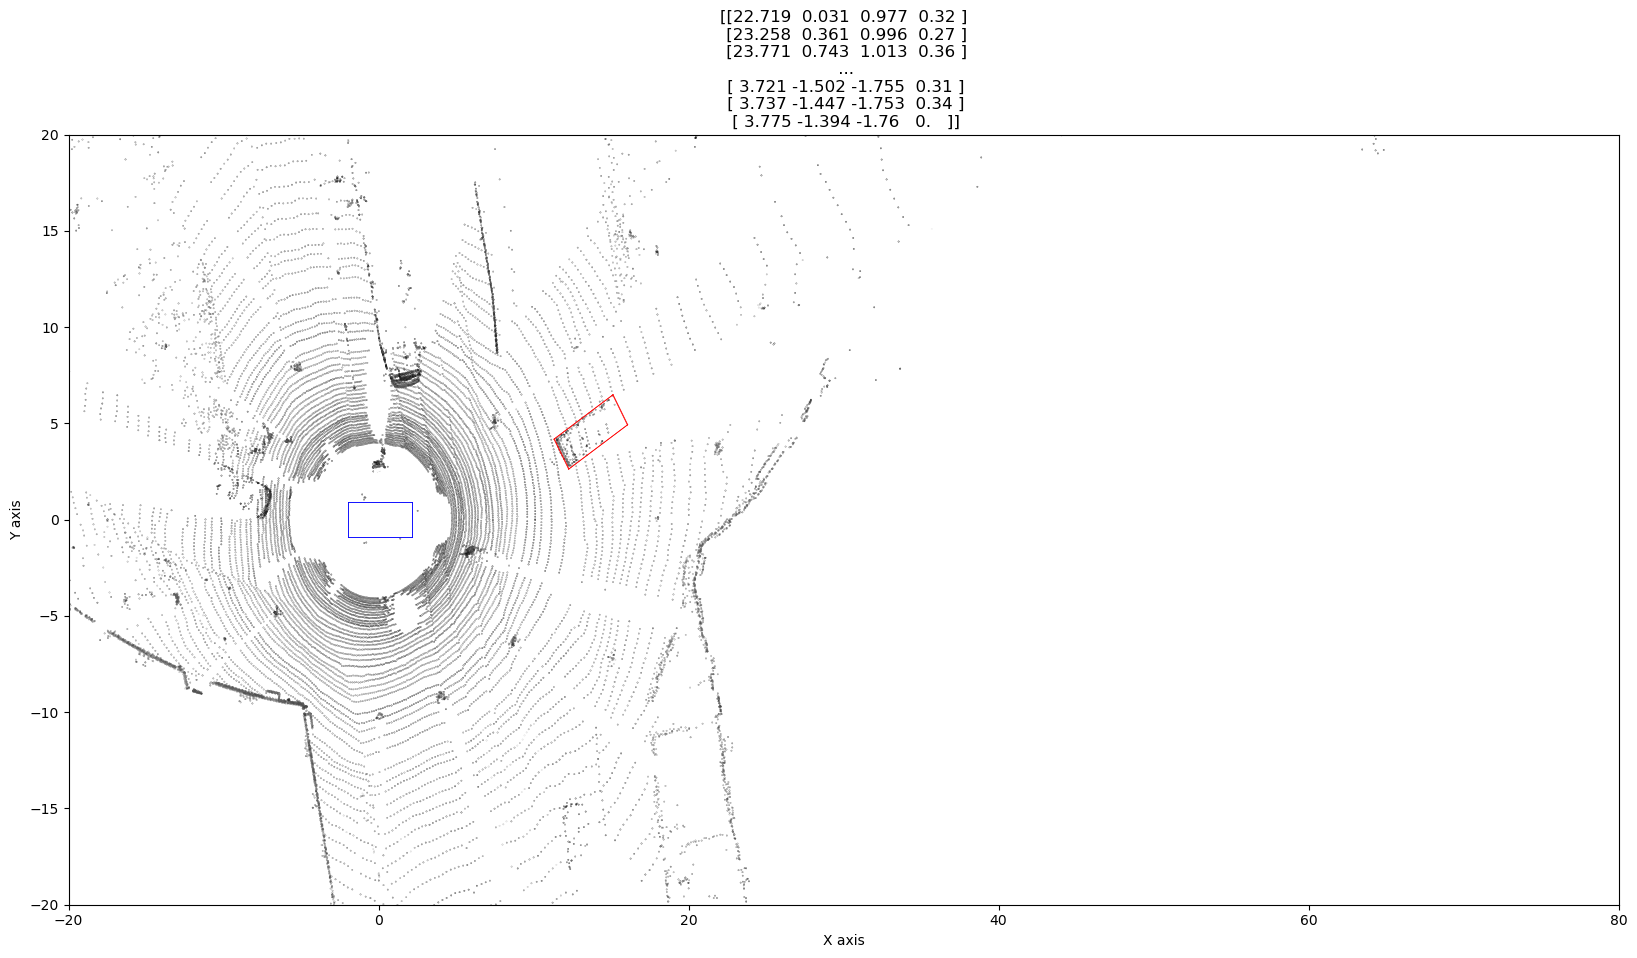

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
draw_point_cloud(ax, points[::5],axes=[0,1])
draw_box(ax, corners_3d_velo.T,axes=[0,1],color='r')
draw_box(ax, ego_car.T,axes=[0,1],color='b')

In [14]:
def distance_point_to_segment(P, A, B):
    AP = P - A
    BP = P - B
    AB = B - A
    if np.dot(AB, AP) > 0 and np.dot(-AB, BP) >= 0:  # P is in line AB
        return np.abs(np.cross(AP, AB)) / np.linalg.norm(AB), np.dot(AP, AB) / np.dot(AB, AB) * AB + A
    d_PA = np.linalg.norm(AP)  # P is outside triangle (not in line AB)
    d_PB = np.linalg.norm(BP)
    if d_PA < d_PB:
        return d_PA, A
    return d_PB, B


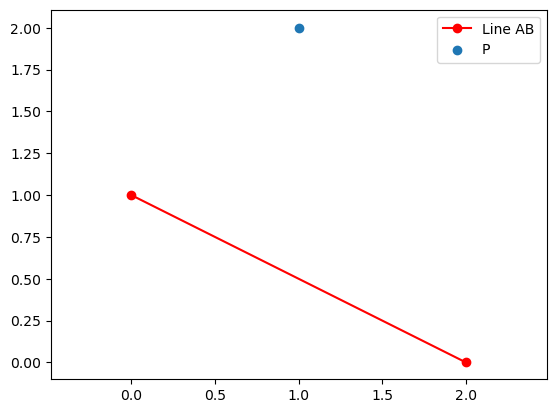

In [15]:
import numpy as np
import matplotlib.pyplot as plt

P = np.array([1, 2], dtype=np.float64)
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)

plt.axes().set_aspect('equal', 'datalim')
plt.scatter(P[0], P[1], label='P')  # 绘制散点图
plt.plot([A[0], B[0]], [A[1], B[1]], 'r-o', label='Line AB')  # 绘制线段
plt.legend()  # 添加图例

plt.show()  # 显示图形


In [16]:
distance_point_to_segment(P,A,B)

(1.3416407864998738, array([0.4, 0.8]))

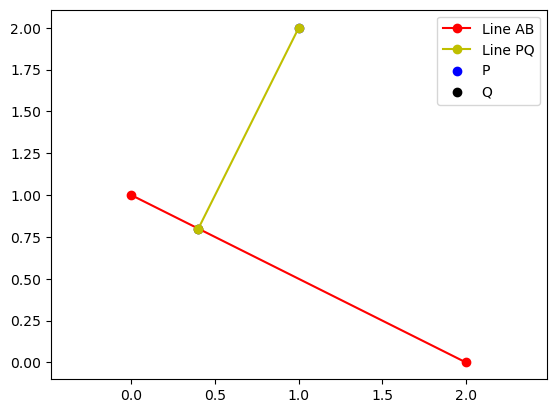

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 点P、线段AB和点Q的坐标
P = np.array([1, 2], dtype=np.float64)
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)

# 计算点P到线段AB的最短距离和最短距离点Q的坐标
d, Q = distance_point_to_segment(P, A, B)

# 设置图形比例为相等
plt.axes().set_aspect('equal', 'datalim')

# 绘制散点图和线段
plt.scatter(P[0], P[1], label='P', color='blue')  # 绘制点P，使用蓝色
plt.plot([A[0], B[0]], [A[1], B[1]], 'r-o', label='Line AB')  # 绘制线段AB，使用红色
plt.scatter(Q[0], Q[1], label='Q', color='black')  # 绘制点Q，使用黑色
plt.plot([P[0], Q[0]], [P[1], Q[1]], 'y-o', label='Line PQ')  # 绘制线段PQ，使用黄色

# 添加图例
plt.legend()

# 显示图形
plt.show()


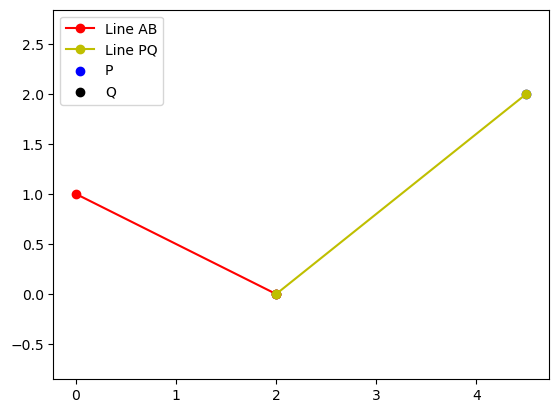

In [18]:
 import numpy as np
import matplotlib.pyplot as plt

# 点P、线段AB和点Q的坐标
P = np.array([4.5, 2], dtype=np.float64)
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)

# 计算点P到线段AB的最短距离和最短距离点Q的坐标
d, Q = distance_point_to_segment(P, A, B)

# 设置图形比例为相等
plt.axes().set_aspect('equal', 'datalim')

# 绘制散点图和线段
plt.scatter(P[0], P[1], label='P', color='blue')  # 绘制点P，使用蓝色
plt.plot([A[0], B[0]], [A[1], B[1]], 'r-o', label='Line AB')  # 绘制线段AB，使用红色
plt.scatter(Q[0], Q[1], label='Q', color='black')  # 绘制点Q，使用黑色
plt.plot([P[0], Q[0]], [P[1], Q[1]], 'y-o', label='Line PQ')  # 绘制线段PQ，使用黄色

# 添加图例
plt.legend()

# 显示图形
plt.show()


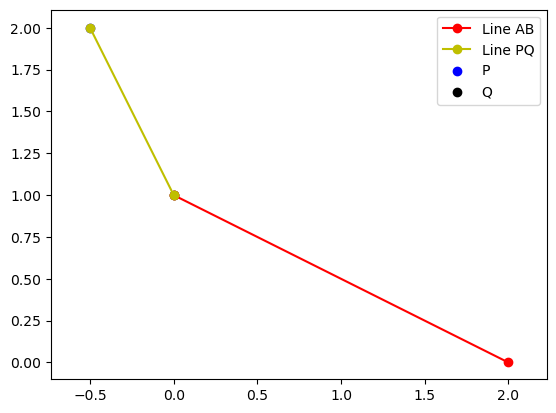

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 点P、线段AB和点Q的坐标
P = np.array([-0.5, 2], dtype=np.float64)
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)

# 计算点P到线段AB的最短距离和最短距离点Q的坐标
d, Q = distance_point_to_segment(P, A, B)

# 设置图形比例为相等
plt.axes().set_aspect('equal', 'datalim')

# 绘制散点图和线段
plt.scatter(P[0], P[1], label='P', color='blue')  # 绘制点P，使用蓝色
plt.plot([A[0], B[0]], [A[1], B[1]], 'r-o', label='Line AB')  # 绘制线段AB，使用红色
plt.scatter(Q[0], Q[1], label='Q', color='black')  # 绘制点Q，使用黑色
plt.plot([P[0], Q[0]], [P[1], Q[1]], 'y-o', label='Line PQ')  # 绘制线段PQ，使用黄色

# 添加图例
plt.legend()

# 显示图形
plt.show()


In [20]:
def min_distance_cuboids(cub1,cub2):
    minD = 1e5
    for i in range(4):
        for j in range(4):
            # 计算点P到线段AB的最短距离和最短距离点Q的坐标
            d, Q = distance_point_to_segment(cub1[i,:2], cub2[j,:2], cub2[j+1,:2])
            if d<minD:
                minD = d
                minP = cub1[i,:2]
                minQ = Q
    for i in range(4):
        for j in range(4):
            # 计算点P到线段AB的最短距离和最短距离点Q的坐标
            d, Q = distance_point_to_segment(cub2[i,:2], cub1[j,:2], cub1[j+1,:2])
            if d<minD:
                minD = d
                minP = cub2[i,:2]
                minQ = Q
    return minP,minQ,minD
            

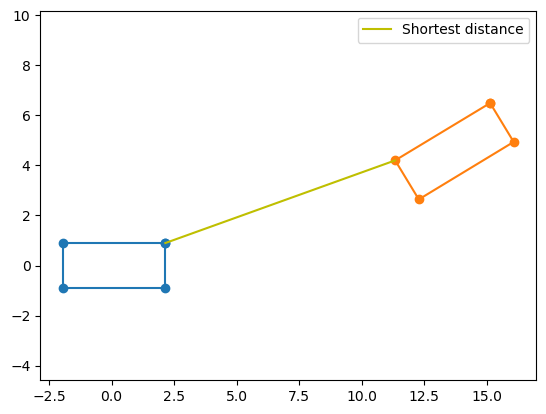

9.75840956934395


In [21]:
# 设置图形比例为相等
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5,0],ego_car[:5,1],'-o')
plt.plot(corners_3d_velo[:5,0],corners_3d_velo[:5,1],'-o')
minP,minQ,minD = min_distance_cuboids(ego_car,corners_3d_velo)
plt.plot([minP[0], minQ[0]], [minP[1], minQ[1]], 'y-', label='Shortest distance')  # 绘制线段PQ，使用黄色
# 添加图例
plt.legend()
# 显示图形
plt.show()

print(minD)

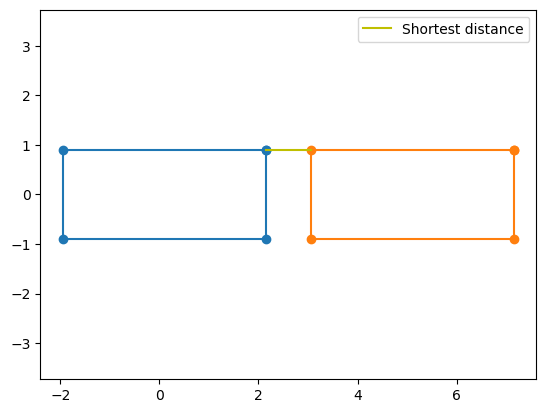

0.8999999999999999


In [22]:
ego_car2 = ego_car.copy()
ego_car2[:,0] += 5 
# 设置图形比例为相等
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5,0],ego_car[:5,1],'-o')
plt.plot(ego_car2[:5,0],ego_car2[:5,1],'-o')
minP,minQ,minD = min_distance_cuboids(ego_car,ego_car2)
plt.plot([minP[0], minQ[0]], [minP[1], minQ[1]], 'y-', label='Shortest distance')  # 绘制线段PQ，使用黄色
# 添加图例
plt.legend()
# 显示图形
plt.show()

print(minD)